# Toy Data: 8-Modes Mixture Model

In [1]:
#In this notebook we use the Freia package and it is heavily based on the notebook published by Ardizzone et al
#see https://github.com/VLL-HD/analyzing_inverse_problems and https://github.com/VLL-HD/analyzing_inverse_problems

# there will be two training blocks in this code. the first one was used to obtain a good first model, and then we did 
# training with more fine tuned weights.

In [5]:
%matplotlib notebook
from time import time
import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
print(device)
print(torch.__version__)

cuda
1.7.1+cu101


<IPython.core.display.Javascript object>


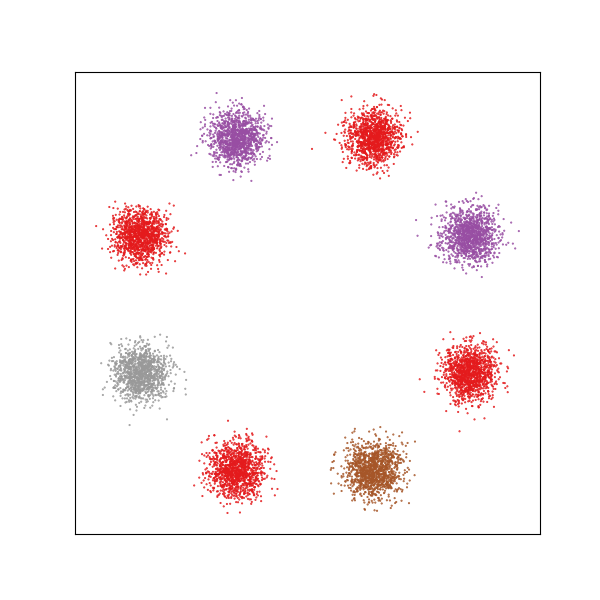

In [6]:
# Generate data
test_split = 10000

pos, labels = data.generate(labels='some2', tot_dataset_size=2**20)
labels = labels[:,:4]

#Visualize data
c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
#Problem Dimensions with padding
ndim_tot = 16
ndim_x = 2
ndim_y = 4
ndim_z = 2

# Construct INN architecture, clamping ensures Lipschitz continuity of network
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 256), nn.ReLU(),
                         nn.Linear(256,  c_out))

nodes = [InputNode(ndim_tot, name='input')]
for k in range(6):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':0.01},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))
nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)

# Construct NN for proabilities in GMM
prob_net = nn.Sequential(nn.Linear(4,64), nn.ReLU(),
                        nn.Linear(64,4), nn.Softmax(dim = 1)).to(device)



In [8]:
# Load pretrained model parameters
model.load_state_dict(torch.load('STABLE_8_LR_noise.pt'))
prob_net.load_state_dict(torch.load('STABLE_8_LR_probs_noise.pt'))

<All keys matched successfully>

In [9]:
# Initial training parameters
n_epochs = 150
n_its_per_epoch = 8
batch_size = 1600

lr_INN = 2e-3
lr_prob = 1e-4
l2_reg = 1e-4 #1e-4

# relative weighting of losses:
lambd_predict = 35. #16
lambd_latent = 100.
lambd_rev = 200. 
lambd_pad = 20.
lambd_prob = 6.

Loss_ramp = True
Sparsity_Reg = False

# Parameters for GMM
gum = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]), validate_args=None)
temp = 0.2
no_gaussians = 4
means = torch.tensor([[-4,-4],[-4,+4],[4,4],[4.,-4.]], device = device)
scale = 1.

# Padding parameters
y_noise_scale = 1e-4
zeros_noise_scale= 1e-4

# Intialize trainable parameters
trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, weight_decay = l2_reg,
  lr=lr_INN, betas=(0.8, 0.9),eps=1e-6)


prob_par = [p for p in prob_net.parameters() if p.requires_grad]
optimizer2 = torch.optim.Adam(prob_par, lr=lr_prob)


# Setup of loss functions
def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

# Data loading routine
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
def train(i_epoch=0):
    model.train()
    l_tot = 0
    batch_idx = 0
    t_start = time()
    
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.
    if Loss_ramp:
        loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    else:
        loss_factor = 1.
    for x, y in train_loader:
        
        # Iterate over number of batches
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break
        optimizer.zero_grad()          
        optimizer2.zero_grad()

        #Pass and create data
        x, y = x.to(device), y.to(device)

        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y + y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)
        
        # Gumbel trick for sampling z
        probs = prob_net(y)
        gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
        logits = gumbs+torch.log(probs)
        maxi,index = torch.max(logits, dim = 1)
        maxi = maxi.view(len(maxi),1)
        maxi = torch.cat((maxi,maxi,maxi,maxi),1)
        #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
        logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
        # Create an array of all possible mixture components with all means
        norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
        # Enlarge logits array to fit the size of norms
        logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
        # linearly combinate the mixture components
        q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
        # put it into z
        z = q+scale*torch.randn(len(y),ndim_z, device = device)
        
        # Pad vectors
        x, y = (torch.cat((x, pad_x),  dim=1),torch.cat((z, pad_yz, y),dim=1))
        
        # Forward step
        output = model(x)
        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)
        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])
        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)
        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()
        l.backward()

        # Backward step
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)
        probs = prob_net(y)
        gumbs = gum.sample((len(y),no_gaussians)).to(device).view(len(y),no_gaussians)
        logits = gumbs+torch.log(probs)
        maxi,index = torch.max(logits, dim = 1)
        maxi = maxi.view(len(maxi),1)
        maxi = torch.cat((maxi,maxi,maxi,maxi),1)
        #logits = torch.exp(logits/temp)/torch.sum(torch.exp(logits/temp), dim = 1).view(len(y),1)
        logits = torch.exp((logits-maxi)/temp)/torch.sum(torch.exp((logits-maxi)/temp), dim = 1).view(len(y),1)
        # Create an array of all possible mixture components with all means
        norms = torch.zeros(len(y),no_gaussians,ndim_z,device = device)+means
        # Enlarge logits array to fit the size of norms
        logits2 = torch.cat((logits.view(len(y),no_gaussians,1),logits.view(len(y),no_gaussians,1)), dim = 2) 
        # linearly combinate the mixture components
        q = torch.sum(logits2*norms, dim = 1).view(len(y),ndim_z)
        # put it into z
        z = q+scale*torch.randn(len(y),ndim_z, device = device)
        
        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale * torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz, output.data[:, -ndim_y:]+ y_noise_scale * torch.randn(batch_size, ndim_y, device=device)), dim=1)
        output_rev = model(y_rev, rev=True)              
        y_rev_rand = torch.cat((z, pad_yz,y), dim=1)
        output_rev_rand = model(y_rev_rand, rev=True)
        l_rev = lambd_rev * loss_factor * loss_backward(
            output_rev_rand[:, :ndim_x],x[:, :ndim_x])
                
        # Add sparsity enforcing regularizer for probability vector
        if Sparsity_Reg:
            l_rev += 1* loss_factor * lambd_prob * torch.mean(torch.square(torch.sum(torch.sqrt(probs),1)))
        
        # Padding loss on y
        l_rev += lambd_predict * loss_fit(output_rev, x)
        l_rev += lambd_pad*torch.mean(output_rev_rand[:,ndim_x:]**2)
                
        l_tot += l_rev.data.item()
        l_rev.backward()

        # Clamping and optimizer steps
        for p in model.parameters():
            p.grad.data.clamp_(-15.00, 15.00)
            
        for p in prob_net.parameters():
            p.grad.data.clamp_(-1.00, 1.00)
        optimizer.step()
        optimizer2.step()


    return l_tot / batch_idx

<IPython.core.display.Javascript object>


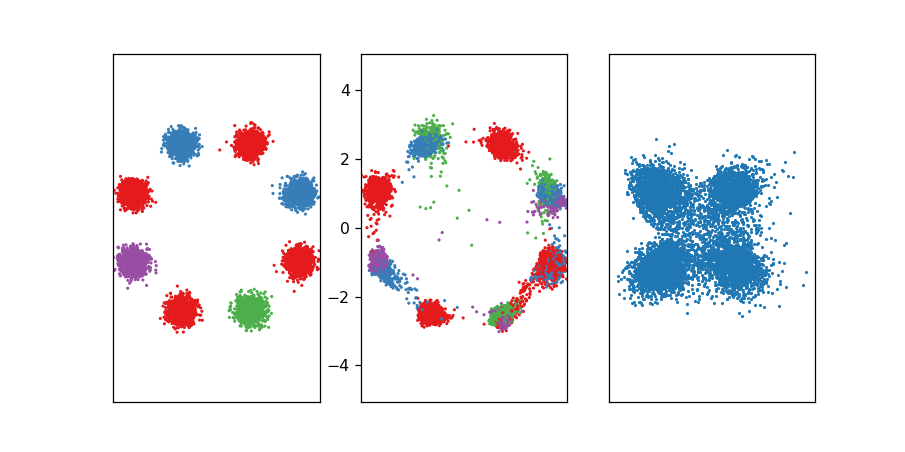

  0%|                                                   | 0/150 [00:00<?, ?it/s]

tensor([[0.2471, 0.2513, 0.2489, 0.2527],
        [0.2471, 0.2513, 0.2489, 0.2527],
        [0.2471, 0.2513, 0.2489, 0.2527],
        [0.2471, 0.2513, 0.2489, 0.2527]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


  7%|##8                                       | 10/150 [00:28<06:38,  2.85s/it]

tensor([[0.2481, 0.2534, 0.2472, 0.2513],
        [0.2482, 0.2535, 0.2470, 0.2513],
        [0.2481, 0.2533, 0.2472, 0.2514],
        [0.2480, 0.2533, 0.2471, 0.2515]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 13%|#####6                                    | 20/150 [00:56<06:07,  2.82s/it]

tensor([[0.2519, 0.2572, 0.2440, 0.2468],
        [0.2525, 0.2578, 0.2433, 0.2464],
        [0.2518, 0.2571, 0.2440, 0.2470],
        [0.2513, 0.2566, 0.2444, 0.2478]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 20%|########4                                 | 30/150 [01:24<05:37,  2.81s/it]

tensor([[0.2599, 0.2652, 0.2374, 0.2375],
        [0.2613, 0.2666, 0.2359, 0.2362],
        [0.2596, 0.2648, 0.2376, 0.2380],
        [0.2568, 0.2621, 0.2397, 0.2414]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 27%|###########2                              | 40/150 [01:52<05:16,  2.88s/it]

tensor([[0.2711, 0.2773, 0.2289, 0.2227],
        [0.2734, 0.2796, 0.2266, 0.2204],
        [0.2696, 0.2758, 0.2299, 0.2247],
        [0.2621, 0.2679, 0.2356, 0.2343]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 33%|##############                            | 50/150 [02:20<04:44,  2.85s/it]

tensor([[0.2757, 0.2811, 0.2285, 0.2147],
        [0.2796, 0.2849, 0.2250, 0.2104],
        [0.2700, 0.2754, 0.2324, 0.2223],
        [0.2598, 0.2651, 0.2387, 0.2364]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 40%|################8                         | 60/150 [02:49<04:16,  2.85s/it]

tensor([[0.2768, 0.2770, 0.2276, 0.2186],
        [0.2854, 0.2841, 0.2208, 0.2097],
        [0.2676, 0.2697, 0.2341, 0.2286],
        [0.2566, 0.2598, 0.2405, 0.2431]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 47%|###################6                      | 70/150 [03:18<03:48,  2.85s/it]

tensor([[0.2812, 0.2761, 0.2243, 0.2184],
        [0.2958, 0.2868, 0.2132, 0.2043],
        [0.2674, 0.2667, 0.2344, 0.2315],
        [0.2572, 0.2578, 0.2398, 0.2452]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 53%|######################4                   | 80/150 [03:46<03:21,  2.88s/it]

tensor([[0.2845, 0.2738, 0.2210, 0.2207],
        [0.3064, 0.2879, 0.2044, 0.2013],
        [0.2661, 0.2627, 0.2350, 0.2363],
        [0.2584, 0.2554, 0.2385, 0.2477]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 60%|#########################2                | 90/150 [04:15<02:54,  2.90s/it]

tensor([[0.2836, 0.2697, 0.2212, 0.2255],
        [0.3145, 0.2892, 0.1973, 0.1991],
        [0.2613, 0.2564, 0.2386, 0.2437],
        [0.2581, 0.2519, 0.2389, 0.2511]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 67%|###########################3             | 100/150 [04:44<02:23,  2.86s/it]

tensor([[0.2817, 0.2656, 0.2211, 0.2316],
        [0.3217, 0.2903, 0.1891, 0.1988],
        [0.2564, 0.2503, 0.2420, 0.2514],
        [0.2568, 0.2479, 0.2394, 0.2559]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 73%|##############################           | 110/150 [05:13<01:57,  2.93s/it]

tensor([[0.2817, 0.2624, 0.2205, 0.2354],
        [0.3309, 0.2918, 0.1809, 0.1964],
        [0.2534, 0.2452, 0.2445, 0.2568],
        [0.2568, 0.2446, 0.2395, 0.2592]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 80%|################################8        | 120/150 [05:42<01:25,  2.85s/it]

tensor([[0.2797, 0.2611, 0.2212, 0.2380],
        [0.3350, 0.2969, 0.1751, 0.1929],
        [0.2520, 0.2426, 0.2457, 0.2597],
        [0.2556, 0.2425, 0.2404, 0.2615]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 87%|###################################5     | 130/150 [06:11<00:58,  2.90s/it]

tensor([[0.2754, 0.2569, 0.2243, 0.2434],
        [0.3410, 0.2970, 0.1698, 0.1922],
        [0.2504, 0.2401, 0.2468, 0.2627],
        [0.2537, 0.2400, 0.2419, 0.2644]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 93%|######################################2  | 140/150 [06:41<00:30,  3.10s/it]

tensor([[0.2734, 0.2554, 0.2252, 0.2459],
        [0.3447, 0.2997, 0.1652, 0.1905],
        [0.2493, 0.2378, 0.2475, 0.2654],
        [0.2529, 0.2384, 0.2422, 0.2665]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


100%|#########################################| 150/150 [07:11<00:00,  2.88s/it]



Training took 7.19 minutes



In [7]:
for param in trainable_parameters:
    param.data = 0.10*torch.randn_like(param)
    
for param in prob_par:
    param.data = 0.005*torch.randn_like(param)
    
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(8,4))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

# Number of samples
N_samp = 8096
inp = torch.tensor([[1., 0., 0., 0.],[0., 1., 0., 0.],[0., 0., 1., 0.],[0., 0., 0., 1.]]).to(device)
x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]

# Index indicating which x has which label
ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
for i in range(ndim_y):
    ind[:,i] = y_samps[:,i].bool()
    
# Beware if y noise is not zero, that the model does not use too much of the y noise 
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
prob_c = prob_net(inp)
# cumulative probabilities
prob_sum = torch.cumsum(prob_c,1)
for i in range(ndim_y):
    # uniform distribution
    shift = torch.rand([sum(ind[:,i].int()),]).float()
    for j in range(no_gaussians):
        shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
    # shift the points corresponding the probabilities
    y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
    y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
y_samps = y_samps.to(device)

            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)
        
        # New part
        y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
        c = np.where(y_samps)[1]
        ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
        for i in range(ndim_y):
            ind[:,i] = y_samps[:,i].bool()

        y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
        y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
        prob_c = prob_net(inp)
        # print the probs
        if np.mod(i_epoch,10)==0:
            print(prob_c)
        prob_sum = torch.cumsum(prob_c,1)
        # shift the y samples
        y_samps = y_samps.to(device)

        for i in range(ndim_y):
            shift = torch.rand([sum(ind[:,i].int()),]).float()
            for j in range(no_gaussians):
                shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
            y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
            y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
        y_samps = y_samps.to(device)
        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, ndim_tot-ndim_y:].argmax(dim=1)
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

                
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3,3,-3,3])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3,3,-3,3])
        axes[1].set_xticks([])
        axes[1].set_yticks
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        #axes[2].axis([-14,14,-14,14])
        axes[2].set_xticks([])
        axes[2].set_yticks([])
    
        
        
        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [8]:
# Tuned training parameters
n_epochs = 200
n_its_per_epoch = 8

temp = 0.1
lr_INN = 1e-3
lr_prob = 1e-3
l2_reg = 7e-2

# relative weighting of losses:
lambd_predict = 15. 
lambd_latent = 150.
lambd_rev = 250. 
lambd_pad = 0.
lambd_prob = 5.

Loss_ramp = False
Sparsity_Reg = True

for g in optimizer.param_groups:
    g['lr'] = lr_INN
    g['weight_decay'] = l2_reg 
        
for g in optimizer2.param_groups:
    g['lr'] = lr_prob

<IPython.core.display.Javascript object>


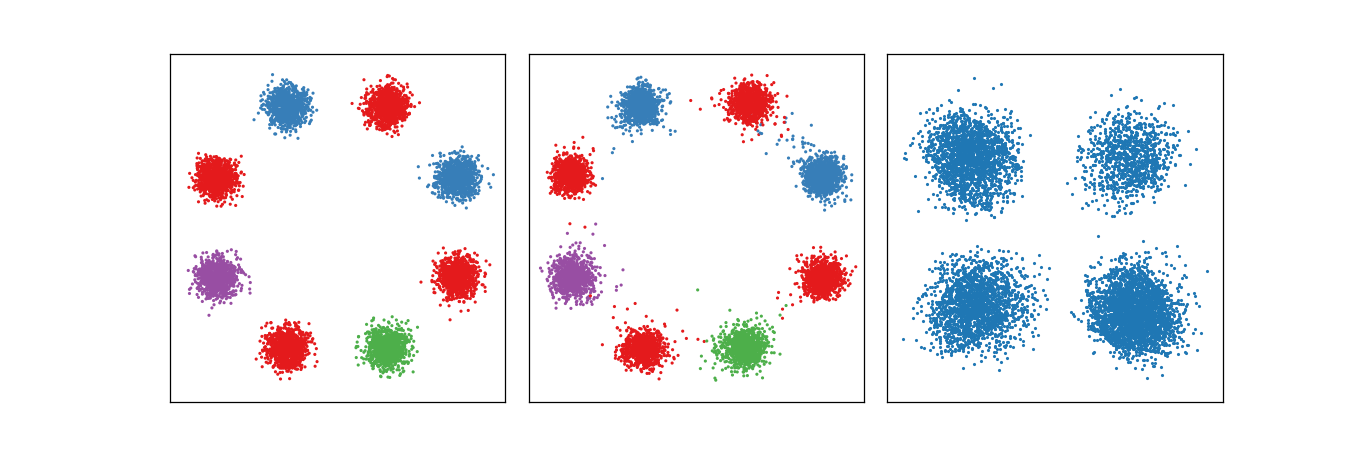

  0%|                                                   | 0/200 [00:00<?, ?it/s]

tensor([[0.2740, 0.2531, 0.2265, 0.2463],
        [0.3624, 0.2997, 0.1574, 0.1805],
        [0.2480, 0.2346, 0.2492, 0.2682],
        [0.2518, 0.2352, 0.2439, 0.2691]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


  5%|##1                                       | 10/200 [00:28<09:21,  2.96s/it]

tensor([[0.2751, 0.2386, 0.2268, 0.2595],
        [0.5028, 0.3778, 0.0483, 0.0710],
        [0.2306, 0.1800, 0.2650, 0.3245],
        [0.2401, 0.1817, 0.2525, 0.3257]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 10%|####2                                     | 20/200 [00:59<09:19,  3.11s/it]

tensor([[0.2935, 0.2384, 0.2073, 0.2608],
        [0.5081, 0.4866, 0.0023, 0.0030],
        [0.1508, 0.0765, 0.2387, 0.5340],
        [0.1570, 0.0736, 0.2135, 0.5560]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 15%|######3                                   | 30/200 [01:28<08:13,  2.90s/it]

tensor([[2.7102e-01, 2.4163e-01, 2.1267e-01, 2.7468e-01],
        [4.8751e-01, 5.1160e-01, 6.1180e-04, 2.7508e-04],
        [3.1878e-02, 1.4569e-02, 7.4572e-02, 8.7898e-01],
        [2.8045e-02, 1.1716e-02, 5.6046e-02, 9.0419e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 20%|########4                                 | 40/200 [01:59<08:14,  3.09s/it]

tensor([[2.6745e-01, 2.4185e-01, 2.2368e-01, 2.6702e-01],
        [5.0036e-01, 4.9926e-01, 3.1259e-04, 6.4793e-05],
        [5.2641e-03, 2.1349e-03, 1.3920e-02, 9.7868e-01],
        [4.9130e-03, 1.9154e-03, 1.1537e-02, 9.8163e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 25%|##########5                               | 50/200 [02:28<07:11,  2.88s/it]

tensor([[2.4883e-01, 2.3444e-01, 2.4107e-01, 2.7566e-01],
        [5.0560e-01, 4.9418e-01, 1.8531e-04, 2.9066e-05],
        [1.4858e-03, 6.3192e-04, 4.2530e-03, 9.9363e-01],
        [1.4827e-03, 6.1749e-04, 3.8725e-03, 9.9403e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 30%|############6                             | 60/200 [02:57<06:39,  2.86s/it]

tensor([[2.5516e-01, 2.5250e-01, 2.4347e-01, 2.4887e-01],
        [4.5578e-01, 5.4410e-01, 9.7690e-05, 1.3210e-05],
        [6.5491e-04, 2.8527e-04, 1.8062e-03, 9.9725e-01],
        [6.7626e-04, 2.9057e-04, 1.7283e-03, 9.9730e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 35%|##############7                           | 70/200 [03:27<06:39,  3.08s/it]

tensor([[2.5239e-01, 2.4854e-01, 2.4939e-01, 2.4968e-01],
        [4.8366e-01, 5.1627e-01, 5.8501e-05, 8.6104e-06],
        [3.4506e-04, 1.4674e-04, 9.0230e-04, 9.9861e-01],
        [3.6542e-04, 1.5412e-04, 9.0117e-04, 9.9858e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 40%|################8                         | 80/200 [03:57<05:51,  2.93s/it]

tensor([[2.4821e-01, 2.4638e-01, 2.4960e-01, 2.5581e-01],
        [5.1126e-01, 4.8870e-01, 3.5395e-05, 5.7478e-06],
        [1.9682e-04, 8.7677e-05, 4.9546e-04, 9.9922e-01],
        [2.1101e-04, 9.3358e-05, 5.0752e-04, 9.9919e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 45%|##################9                       | 90/200 [04:27<05:19,  2.90s/it]

tensor([[2.4233e-01, 2.4667e-01, 2.4725e-01, 2.6375e-01],
        [4.7965e-01, 5.2033e-01, 2.3116e-05, 4.3129e-06],
        [1.2439e-04, 5.6257e-05, 2.9610e-04, 9.9952e-01],
        [1.3701e-04, 6.1763e-05, 3.1611e-04, 9.9949e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 50%|####################5                    | 100/200 [04:56<04:45,  2.85s/it]

tensor([[2.4020e-01, 2.4037e-01, 2.4962e-01, 2.6981e-01],
        [5.0630e-01, 4.9368e-01, 1.5993e-05, 3.2144e-06],
        [8.4190e-05, 3.6181e-05, 1.8948e-04, 9.9969e-01],
        [9.3560e-05, 4.0186e-05, 2.0661e-04, 9.9966e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 55%|######################5                  | 110/200 [05:26<04:28,  2.99s/it]

tensor([[2.4521e-01, 2.4299e-01, 2.5001e-01, 2.6179e-01],
        [4.8955e-01, 5.1043e-01, 1.1368e-05, 2.5054e-06],
        [6.2994e-05, 2.5351e-05, 1.2837e-04, 9.9978e-01],
        [7.0596e-05, 2.8472e-05, 1.4269e-04, 9.9976e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 60%|########################5                | 120/200 [05:52<03:17,  2.47s/it]

tensor([[2.5024e-01, 2.4749e-01, 2.5111e-01, 2.5116e-01],
        [4.8764e-01, 5.1235e-01, 8.7827e-06, 1.8919e-06],
        [4.7077e-05, 1.8622e-05, 9.2190e-05, 9.9984e-01],
        [5.2861e-05, 2.0977e-05, 1.0375e-04, 9.9982e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 65%|##########################6              | 130/200 [06:16<02:48,  2.40s/it]

tensor([[2.5077e-01, 2.4874e-01, 2.5532e-01, 2.4517e-01],
        [4.8052e-01, 5.1947e-01, 7.1582e-06, 1.3839e-06],
        [3.6239e-05, 1.4154e-05, 7.0778e-05, 9.9988e-01],
        [4.0775e-05, 1.5991e-05, 8.0510e-05, 9.9986e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 70%|############################7            | 140/200 [06:40<02:21,  2.36s/it]

tensor([[2.3766e-01, 2.4262e-01, 2.5235e-01, 2.6737e-01],
        [4.8317e-01, 5.1682e-01, 5.6132e-06, 1.3428e-06],
        [2.5465e-05, 1.0920e-05, 4.9728e-05, 9.9991e-01],
        [2.8890e-05, 1.2434e-05, 5.7467e-05, 9.9990e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 75%|##############################7          | 150/200 [07:04<02:00,  2.41s/it]

tensor([[2.4167e-01, 2.4811e-01, 2.5048e-01, 2.5975e-01],
        [4.9065e-01, 5.0934e-01, 4.2214e-06, 1.0958e-06],
        [2.0005e-05, 8.9183e-06, 3.7650e-05, 9.9993e-01],
        [2.2868e-05, 1.0237e-05, 4.4223e-05, 9.9992e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 80%|################################8        | 160/200 [07:29<01:40,  2.50s/it]

tensor([[2.4101e-01, 2.4441e-01, 2.4838e-01, 2.6620e-01],
        [4.5966e-01, 5.4033e-01, 3.2972e-06, 9.3831e-07],
        [1.6396e-05, 6.7965e-06, 2.8625e-05, 9.9995e-01],
        [1.8870e-05, 7.8662e-06, 3.4126e-05, 9.9994e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 85%|##################################8      | 170/200 [07:54<01:13,  2.45s/it]

tensor([[2.4801e-01, 2.4548e-01, 2.4659e-01, 2.5992e-01],
        [4.5955e-01, 5.4045e-01, 2.7082e-06, 8.1084e-07],
        [1.4165e-05, 5.3360e-06, 2.2581e-05, 9.9996e-01],
        [1.6389e-05, 6.2212e-06, 2.7292e-05, 9.9995e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 90%|####################################9    | 180/200 [08:21<00:54,  2.71s/it]

tensor([[2.4870e-01, 2.4612e-01, 2.5396e-01, 2.5122e-01],
        [5.0280e-01, 4.9720e-01, 2.5239e-06, 8.1416e-07],
        [1.1753e-05, 4.6129e-06, 1.8762e-05, 9.9996e-01],
        [1.3682e-05, 5.4150e-06, 2.2983e-05, 9.9996e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 95%|######################################9  | 190/200 [08:49<00:28,  2.83s/it]

tensor([[2.4112e-01, 2.4070e-01, 2.5289e-01, 2.6529e-01],
        [4.5823e-01, 5.4177e-01, 2.0355e-06, 7.3245e-07],
        [9.2918e-06, 3.7005e-06, 1.4409e-05, 9.9997e-01],
        [1.0857e-05, 4.3587e-06, 1.7832e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


100%|#########################################| 200/200 [09:20<00:00,  2.80s/it]



Training took 9.34 minutes



In [9]:
model.to(device)

fig, axes = plt.subplots(1, 3,figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096
inp = torch.tensor([[1., 0., 0., 0.],[0., 1., 0., 0.],[0., 0., 1., 0.],[0., 0., 0., 1.]]).to(device)

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]

y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
for i in range(ndim_y):
    ind[:,i] = y_samps[:,i].bool()
y_samps += 0*torch.randn(N_samp, ndim_y)
y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
prob_c = prob_net(inp)
prob_sum = torch.cumsum(prob_c,1)
for i in range(ndim_y):
    shift = torch.rand([sum(ind[:,i].int()),]).float()
    for j in range(no_gaussians):
        shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
    y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
    y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
y_samps = y_samps.to(device)

            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)
        
        # New part
        y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
        c = np.where(y_samps)[1]
        ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
        for i in range(ndim_y):
            ind[:,i] = y_samps[:,i].bool()
        y_samps += 0* torch.randn(N_samp, ndim_y)
        y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
        prob_c = prob_net(inp)
        if np.mod(i_epoch,10)==0:
            print(prob_c)
        prob_sum = torch.cumsum(prob_c,1)
        y_samps = y_samps.to(device)
        for i in range(ndim_y):
            shift = torch.rand([sum(ind[:,i].int()),]).float()
            for j in range(no_gaussians):
                shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
            y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
            y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
        y_samps = y_samps.to(device)
        # End new part
        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, ndim_tot-ndim_y:].argmax(dim=1)
        z_val = model(torch.cat((x_samps, zeros_noise_scale * torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))
                
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:, 0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        

        if i_epoch == n_epochs-1:
        
            plt.savefig('LR.png', bbox_inches = 'tight')

    
        
    
        fig.canvas.draw()
        


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [10]:
# Tuned training parameters
n_epochs = 200
n_its_per_epoch = 8

temp = 0.06
lr_INN = 4e-4
lr_prob = 4e-4
l2_reg = 1e-4

# relative weighting of losses:
lambd_predict = 5. 
lambd_latent = 150.
lambd_rev = 250. 
lambd_pad = 0.
lambd_prob = 5.

Loss_ramp = False
Sparsity_Reg = False

for g in optimizer.param_groups:
    g['lr'] = lr_INN
    g['weight_decay'] = l2_reg 
        
for g in optimizer2.param_groups:
    g['lr'] = lr_prob

<IPython.core.display.Javascript object>


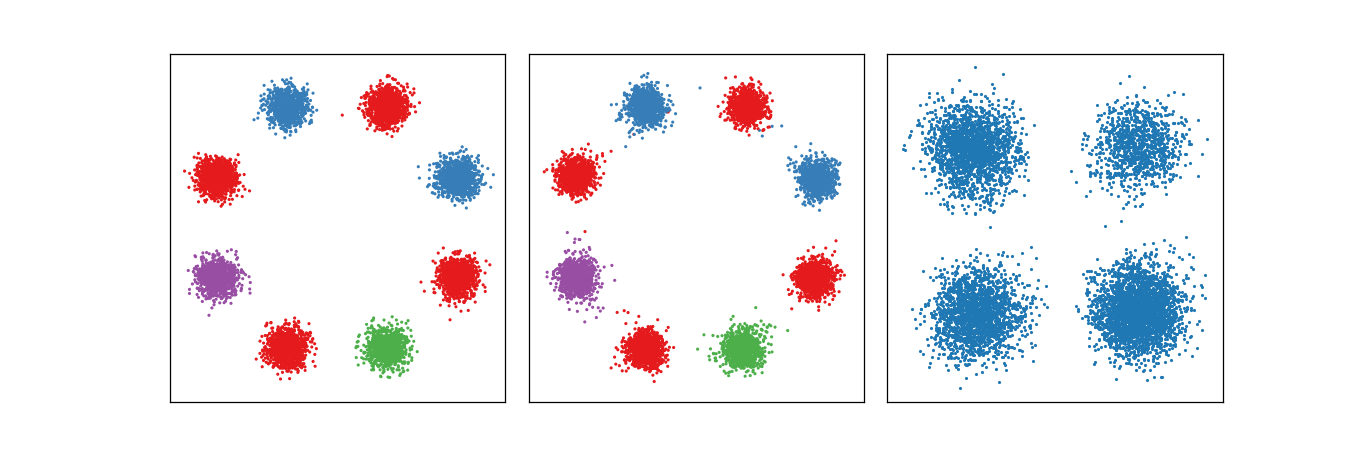

  0%|                                                   | 0/200 [00:00<?, ?it/s]

tensor([[2.5302e-01, 2.4361e-01, 2.4745e-01, 2.5592e-01],
        [4.9199e-01, 5.0801e-01, 1.6056e-06, 6.1714e-07],
        [8.4070e-06, 3.0519e-06, 1.1659e-05, 9.9998e-01],
        [9.8383e-06, 3.6065e-06, 1.4554e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


  5%|##1                                       | 10/200 [00:28<09:08,  2.89s/it]

tensor([[2.4890e-01, 2.4165e-01, 2.5572e-01, 2.5372e-01],
        [4.9387e-01, 5.0613e-01, 1.7688e-06, 6.2718e-07],
        [8.2856e-06, 3.0860e-06, 1.2211e-05, 9.9998e-01],
        [9.6978e-06, 3.6464e-06, 1.5237e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 10%|####2                                     | 20/200 [00:59<09:29,  3.16s/it]

tensor([[2.5386e-01, 2.4798e-01, 2.5112e-01, 2.4704e-01],
        [5.0327e-01, 4.9672e-01, 1.6859e-06, 6.3745e-07],
        [8.2726e-06, 3.2200e-06, 1.2020e-05, 9.9998e-01],
        [9.6833e-06, 3.8030e-06, 1.5001e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 15%|######3                                   | 30/200 [01:28<08:26,  2.98s/it]

tensor([[2.5172e-01, 2.4565e-01, 2.4918e-01, 2.5346e-01],
        [5.0318e-01, 4.9681e-01, 1.6908e-06, 6.6757e-07],
        [8.1618e-06, 3.1766e-06, 1.1804e-05, 9.9998e-01],
        [9.5768e-06, 3.7613e-06, 1.4767e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 20%|########4                                 | 40/200 [01:57<07:49,  2.94s/it]

tensor([[2.4946e-01, 2.4664e-01, 2.5245e-01, 2.5145e-01],
        [4.8741e-01, 5.1259e-01, 1.7826e-06, 6.6243e-07],
        [8.1296e-06, 3.2225e-06, 1.2119e-05, 9.9998e-01],
        [9.5698e-06, 3.8277e-06, 1.5203e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 25%|##########5                               | 50/200 [02:27<07:44,  3.10s/it]

tensor([[2.4671e-01, 2.4616e-01, 2.5062e-01, 2.5651e-01],
        [4.7713e-01, 5.2287e-01, 1.7606e-06, 6.8104e-07],
        [7.9443e-06, 3.2313e-06, 1.1881e-05, 9.9998e-01],
        [9.3543e-06, 3.8376e-06, 1.4908e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 30%|############6                             | 60/200 [02:58<07:23,  3.17s/it]

tensor([[2.5287e-01, 2.4783e-01, 2.5193e-01, 2.4737e-01],
        [5.0682e-01, 4.9317e-01, 1.7942e-06, 6.6674e-07],
        [8.2198e-06, 3.2454e-06, 1.2159e-05, 9.9998e-01],
        [9.6741e-06, 3.8550e-06, 1.5253e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 35%|##############7                           | 70/200 [03:29<06:39,  3.07s/it]

tensor([[2.5285e-01, 2.5110e-01, 2.5151e-01, 2.4454e-01],
        [4.9652e-01, 5.0347e-01, 1.8013e-06, 6.7028e-07],
        [8.1885e-06, 3.3185e-06, 1.2199e-05, 9.9998e-01],
        [9.6386e-06, 3.9408e-06, 1.5303e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 40%|################8                         | 80/200 [04:00<06:11,  3.10s/it]

tensor([[2.4832e-01, 2.4845e-01, 2.5190e-01, 2.5134e-01],
        [4.8187e-01, 5.1813e-01, 1.8363e-06, 6.9180e-07],
        [8.0436e-06, 3.2809e-06, 1.2106e-05, 9.9998e-01],
        [9.4724e-06, 3.8973e-06, 1.5190e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 45%|##################9                       | 90/200 [04:32<05:53,  3.21s/it]

tensor([[2.4723e-01, 2.4792e-01, 2.5275e-01, 2.5210e-01],
        [4.6409e-01, 5.3590e-01, 1.8780e-06, 6.9960e-07],
        [8.0666e-06, 3.2580e-06, 1.2153e-05, 9.9998e-01],
        [9.4993e-06, 3.8696e-06, 1.5247e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 50%|####################5                    | 100/200 [05:03<05:19,  3.20s/it]

tensor([[2.5043e-01, 2.5033e-01, 2.4906e-01, 2.5018e-01],
        [4.7953e-01, 5.2047e-01, 1.8531e-06, 7.4093e-07],
        [8.0297e-06, 3.2642e-06, 1.1830e-05, 9.9998e-01],
        [9.4872e-06, 3.8912e-06, 1.4898e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 55%|######################5                  | 110/200 [05:35<04:42,  3.14s/it]

tensor([[2.4816e-01, 2.4836e-01, 2.5402e-01, 2.4946e-01],
        [4.9402e-01, 5.0598e-01, 2.0027e-06, 7.3650e-07],
        [7.9479e-06, 3.3228e-06, 1.2281e-05, 9.9998e-01],
        [9.3916e-06, 3.9606e-06, 1.5460e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 60%|########################5                | 120/200 [06:06<04:11,  3.15s/it]

tensor([[2.4516e-01, 2.4350e-01, 2.5131e-01, 2.6003e-01],
        [4.7985e-01, 5.2014e-01, 1.9826e-06, 7.8293e-07],
        [7.9157e-06, 3.1778e-06, 1.1850e-05, 9.9998e-01],
        [9.3524e-06, 3.7887e-06, 1.4920e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 65%|##########################6              | 130/200 [06:32<02:53,  2.48s/it]

tensor([[2.5339e-01, 2.5281e-01, 2.5017e-01, 2.4364e-01],
        [4.7020e-01, 5.2980e-01, 1.9739e-06, 7.3978e-07],
        [8.2096e-06, 3.2873e-06, 1.2142e-05, 9.9998e-01],
        [9.6990e-06, 3.9186e-06, 1.5287e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 70%|############################7            | 140/200 [06:56<02:26,  2.45s/it]

tensor([[2.4935e-01, 2.4614e-01, 2.4894e-01, 2.5557e-01],
        [4.9173e-01, 5.0827e-01, 1.9877e-06, 8.2436e-07],
        [8.0044e-06, 3.1677e-06, 1.1678e-05, 9.9998e-01],
        [9.4694e-06, 3.7831e-06, 1.4731e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 75%|##############################7          | 150/200 [07:21<02:15,  2.72s/it]

tensor([[2.4425e-01, 2.4099e-01, 2.4983e-01, 2.6493e-01],
        [4.8393e-01, 5.1607e-01, 2.0841e-06, 8.7285e-07],
        [7.8689e-06, 3.0870e-06, 1.1576e-05, 9.9998e-01],
        [9.3235e-06, 3.6931e-06, 1.4624e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 80%|################################8        | 160/200 [07:51<01:58,  2.97s/it]

tensor([[2.5170e-01, 2.4813e-01, 2.4661e-01, 2.5357e-01],
        [5.0311e-01, 4.9689e-01, 2.0061e-06, 8.5289e-07],
        [8.0778e-06, 3.2071e-06, 1.1590e-05, 9.9998e-01],
        [9.5673e-06, 3.8355e-06, 1.4642e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 85%|##################################8      | 170/200 [08:21<01:34,  3.16s/it]

tensor([[2.4983e-01, 2.4907e-01, 2.5081e-01, 2.5029e-01],
        [4.8029e-01, 5.1971e-01, 2.1376e-06, 8.4433e-07],
        [8.0953e-06, 3.2649e-06, 1.1944e-05, 9.9998e-01],
        [9.5291e-06, 3.8765e-06, 1.4965e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 90%|####################################9    | 180/200 [08:52<01:02,  3.12s/it]

tensor([[2.5117e-01, 2.4707e-01, 2.5106e-01, 2.5070e-01],
        [5.1153e-01, 4.8846e-01, 2.1927e-06, 8.7327e-07],
        [8.1133e-06, 3.2586e-06, 1.1968e-05, 9.9998e-01],
        [9.5432e-06, 3.8673e-06, 1.4985e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


 95%|######################################9  | 190/200 [09:24<00:31,  3.14s/it]

tensor([[2.5290e-01, 2.5079e-01, 2.5048e-01, 2.4584e-01],
        [4.8795e-01, 5.1204e-01, 2.2471e-06, 8.6413e-07],
        [8.2152e-06, 3.3080e-06, 1.2067e-05, 9.9998e-01],
        [9.6439e-06, 3.9166e-06, 1.5078e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


100%|#########################################| 200/200 [09:55<00:00,  2.98s/it]



Training took 9.92 minutes



In [11]:
model.to(device)

fig, axes = plt.subplots(1, 3,figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096
inp = torch.tensor([[1., 0., 0., 0.],[0., 1., 0., 0.],[0., 0., 1., 0.],[0., 0., 0., 1.]]).to(device)

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]

y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
for i in range(ndim_y):
    ind[:,i] = y_samps[:,i].bool()
y_samps += 0*torch.randn(N_samp, ndim_y)
y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
prob_c = prob_net(inp)
prob_sum = torch.cumsum(prob_c,1)
for i in range(ndim_y):
    shift = torch.rand([sum(ind[:,i].int()),]).float()
    for j in range(no_gaussians):
        shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
    y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
    y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
y_samps = y_samps.to(device)

            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)
        
        # New part
        y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
        c = np.where(y_samps)[1]
        ind = torch.zeros(N_samp, ndim_y, dtype = bool, device=device)
        for i in range(ndim_y):
            ind[:,i] = y_samps[:,i].bool()
        y_samps += 0* torch.randn(N_samp, ndim_y)
        y_samps = torch.cat([scale*torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
        prob_c = prob_net(inp)
        if np.mod(i_epoch,10)==0:
            print(prob_c)
        prob_sum = torch.cumsum(prob_c,1)
        y_samps = y_samps.to(device)
        for i in range(ndim_y):
            shift = torch.rand([sum(ind[:,i].int()),]).float()
            for j in range(no_gaussians):
                shift[(0<shift)&(shift<prob_sum[i,j].cpu())] = j
            y_samps[ind[:,i],0] += means[shift.int().flatten().tolist(),0]
            y_samps[ind[:,i],1] += means[shift.int().flatten().tolist(),1]
        y_samps = y_samps.to(device)
        # End new part
        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, ndim_tot-ndim_y:].argmax(dim=1)
        z_val = model(torch.cat((x_samps, zeros_noise_scale * torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))
                
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:, 0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        

        if i_epoch == n_epochs-1:
        
            plt.savefig('LR.png', bbox_inches = 'tight')

    
        
    
        fig.canvas.draw()
        


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [13]:
torch.save(model.state_dict(), 'STABLE_8_LR_noise.pt')
torch.save(prob_net.state_dict(), 'STABLE_8_LR_probs_noise.pt')

In [14]:
print(prob_net(inp))

tensor([[2.4665e-01, 2.4681e-01, 2.5204e-01, 2.5451e-01],
        [4.8637e-01, 5.1363e-01, 2.3483e-06, 9.1179e-07],
        [7.9232e-06, 3.2927e-06, 1.1992e-05, 9.9998e-01],
        [9.3070e-06, 3.8996e-06, 1.4990e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
